## STEP 1 : DATA IMPORT

In [ ]:
import pandas as pd

train_data = pd.read_csv('data/train.csv')
print('Training data set: ' + str(len(train_data)))

#train_data.head()

## STEP 2 : DATA WRANGLING

In [ ]:
%%time

import contractions
import re
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
#nltk.download()
from nltk.stem import PorterStemmer, WordNetLemmatizer  
from nltk.tokenize import word_tokenize 
from nltk.corpus import  wordnet, stopwords 
from joblib import dump, load

stop_words = set(stopwords.words('english'))

def remove_non_ascii(text):
    return ''.join(i for i in text if ord(i)<128)

def remove_white_space(text):
    return text.strip().strip('\t\n')

def remove_special_character(text):
    return re.sub('[^A-Za-z0-9\s]+', '', text)

def porter_stemmer(text): #PorterStemmer
    ps = PorterStemmer()
    text = ' '.join([ps.stem(word) for word in word_tokenize(text)])
    return text

def lemmatizer(text): 
    lemmatizer = WordNetLemmatizer()
    text = ' '.join([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(text)])
    return text

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)
    
def remove_stop_word(text): 
    text = ' '.join([w for w in nltk.word_tokenize(text) if w not in stop_words])
    return text

train_data['origin'] = train_data['question_text']
train_data['question_text'] = train_data['question_text'].str.normalize('NFKD')\
.apply(remove_non_ascii).apply(remove_white_space).apply(contractions.fix).str.lower()\
.apply(remove_special_character).apply(remove_stop_word)

train_data['question_text_stem'] = train_data['question_text'].apply(porter_stemmer)
train_data['question_text_lemma'] = train_data['question_text'].apply(lemmatizer)
train_data['word_count'] = train_data['question_text'].apply(lambda x: len(str(x).split()))
train_data = train_data.loc[(train_data.word_count > 0)]
train_data= train_data.reset_index()

print('Training data set: ' + str(len(train_data)))
#print(train_data.head())

filename = 'data/train_data.sav'
dump(train_data, filename)

<B>Data Staging</B>

In [ ]:
from joblib import dump, load
filename = 'data/train_data.sav'
train_data = load(filename)
print('Training data set: ' + str(len(train_data)))

In [ ]:
%%time

from joblib import dump, load

train_text_lemma = train_data['question_text_lemma']
train_text_stem = train_data['question_text_stem']
train_target = train_data['target']

filename = 'data/target.sav'
dump(train_target, filename)
filename = 'data/question_text_lemma.sav'
dump(train_text_lemma, filename)
filename = 'data/question_text_stem.sav'
dump(train_text_stem, filename)

## STEP 3 : WORD CLOUD  (optional, see earlier submission)


## STEP 4 : SPLIT DATA FOR TRAINING, TESTING, AND HOLDING

## <font color="red">Step 4.0 code library section</font>

In [1]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix, classification_report, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns
import matplotlib.pyplot as plt

def split(X, y, vectorizer=CountVectorizer(), test_size=0.2, hold_size=0.2):
    #split data to train, test & hold, hold will be completed outside the training vector, 
    X_train, X_hold, y_train, y_hold  = train_test_split(X, y, test_size = hold_size, train_size = 1 - hold_size, random_state = 42, stratify = y)
    X_train = vectorizer.fit_transform(X_train)
    X_hold = vectorizer.transform(X_hold)
    X_train, X_test, y_train, y_test  = train_test_split(X_train, y_train, test_size = test_size, train_size = 1 - test_size, random_state = 42, stratify = y_train)
    return  X_train, X_test, X_hold, y_train, y_test, y_hold, vectorizer


def fit(X, y, param_grid, estimator):
    search = GridSearchCV(estimator, param_grid, cv=5,verbose=1, scoring='roc_auc')
    # search = GridSearchCV(estimator, param_grid, cv=5,verbose=1, refit='f1', scoring={'f1','precision','recall'})
    search.fit(X, y)
    best= search.best_estimator_ 
    best.fit(X, y)
    return best


def report(best, X, y, comp, name):
    target_names = ['Sincere', 'Insincere']
    
    print(best)
    predicted = best.predict(X)
    
    #classification_report 
    report = classification_report(y, predicted, target_names=target_names)
    print(report)
    comp[name] = report

    #confusion matrix
    matrix = confusion_matrix(y, predicted)
    fig, ax = plt.subplots(figsize=(5,5))
    sns.heatmap(matrix, annot=True, fmt='d')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
    
    #roc curve
    probs = best.predict_proba(X)
    fpr, tpr, thresholds = roc_curve(y, probs[:,0], pos_label= 0)
    roc_auc = auc(fpr, tpr)
    fpr1, tpr1, thresholds1 = roc_curve(y, probs[:,1], pos_label= 1)
    roc_auc1 = auc(fpr1, tpr1)
    
    plt.figure()
    plt.plot(fpr, tpr, color='blue', lw=1, label='ROC curve for sincere (area = %0.2f)' % roc_auc)
    plt.plot(fpr1, tpr1, color='red', lw=1, label='ROC curve for insincere (area = %0.2f)' % roc_auc1)
    plt.plot([0, 1], [0, 1], color='black', lw=1, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

In [2]:
%%time

from joblib import dump, load

filename = 'data/target.sav'
train_target =load(filename)
filename = 'data/question_text_lemma.sav'
train_text_lemma = load(filename)
filename = 'data/question_text_stem.sav'
train_text_stem = load(filename)

CPU times: user 970 ms, sys: 326 ms, total: 1.3 s
Wall time: 1.33 s


In [3]:
%%time

X_train, X_test, X_hold, y_train, y_test, y_hold, vectorizer = split(train_text_lemma, train_target,)
print(X_train.shape,X_test.shape,X_hold.shape)
print(y_train.shape,y_test.shape,y_hold.shape)
print(vectorizer)


(835852, 196257) (208964, 196257) (261204, 196257)
(835852,) (208964,) (261204,)
CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)
CPU times: user 13.8 s, sys: 389 ms, total: 14.2 s
Wall time: 12.4 s


## STEP 5 : INITIAL EVALUATION

### Evaluate the learning curve on training data size

<font color="red">Although there has no significant elbow point in the plot, 25% of the training data appears as a good smallest set for the ML model comparison step</font>

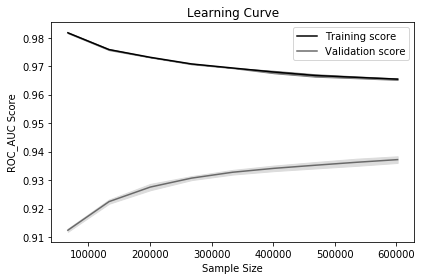

CPU times: user 12min 15s, sys: 13.1 s, total: 12min 28s
Wall time: 3min 8s


In [4]:
%%time

from sklearn.model_selection import learning_curve
from sklearn.linear_model import LogisticRegression
import numpy as np

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


train_sizes, train_scores, valid_scores = learning_curve(
    LogisticRegression(), X_train, y_train, train_sizes = np.arange(0.1, 1, 0.1), cv = 5, scoring = 'roc_auc')


# Calculate mean and standard deviation
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
valid_mean = np.mean(valid_scores, axis=1)
valid_std = np.std(valid_scores, axis=1)

# Plot mean accuracy scores for training and test sets
plt.plot(train_sizes, train_mean, color='black', label="Training score",)
plt.plot(train_sizes, valid_mean, color='dimgrey', label="Validation score", )
# Plot accurancy bands for training and test sets
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="gray")
plt.fill_between(train_sizes, valid_mean - valid_std, valid_mean + valid_std, color="gainsboro")

# Create plot
plt.title("Learning Curve")
plt.xlabel("Sample Size")
plt.ylabel("ROC_AUC Score")
plt.tight_layout()
plt.legend(loc="best")
plt.show()

### Evaluate the validation curve on regularization strength 

<font color="red">GridSearchCV should handle individual parameter selection. This plot just to show the effect for parameter selection</font>

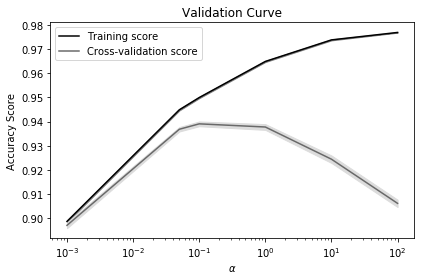

CPU times: user 1.56 s, sys: 361 ms, total: 1.93 s
Wall time: 5min 33s


In [5]:
%%time

import numpy as np
from sklearn.model_selection import validation_curve
from sklearn.linear_model import LogisticRegression

# Calculate accuracy on training and test set using range of parameter values
param_range = [0.001, 0.05, 0.1, 1, 10, 100]
train_scores, test_scores = validation_curve(LogisticRegression(), 
                                             X_train, 
                                             y_train, 
                                             param_name="C", 
                                             param_range=param_range,
                                             cv=5, 
                                             scoring="roc_auc", 
                                             n_jobs=-1)
 
# Calculate mean and standard deviation for training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot mean accuracy scores for training and test sets
plt.plot(param_range, train_mean, label="Training score", color="black")
plt.plot(param_range, test_mean, label="Cross-validation score", color="dimgrey")
# Plot accurancy bands for training and test sets
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color="gray")
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, color="gainsboro")

# Create plot
plt.title("Validation Curve")
plt.xlabel(r"$\alpha$")
plt.xscale('log')
plt.ylabel("Accuracy Score")
plt.tight_layout()
plt.legend(loc="best")
plt.show()

### Eevaluate the resampling due to imbalanced data   

<font color='red'> As in the early prototype submission, the best f-1 score for insincere class barely reach 0.50 (using 0.5% sample for training), the attempt is to apply [imbalance library](https://imbalanced-learn.readthedocs.io/en/stable/) to improve the f-1 score. To save on computation time, the logistic regression model is used to test different sampling methods. The reason is the logistic regression provides reasonable result in a relatively short time. A few sampling approaches are embedded within modeling algorithm,  a default parameter will be used withs out CV or GridSearch. This is to decide on re-sampling method, not on model optimizing </font> 

<B>The over sampling, under sampling and SMOT provides similar f-1 score, in which aoc_ROC is 0.94. The ADASYN, SMOTEENN both has lower aoc_ROC score and take longer time to complete.  the SMOTETomek does not complete in a reasonable time that I have to interrupt the thread after 30 hours of running. The Ensemble models report f-1 scores slightly below SMOT, ranging from (0.84 ~ 0.93). The SMOT will be adopted to continue to the next step.     
</B>

In [4]:
sample_compare = {}

In [5]:
%%time

from sklearn.linear_model import LogisticRegression
org_model = LogisticRegression(solver='liblinear').fit(X_train, y_train)


CPU times: user 51.4 s, sys: 653 ms, total: 52 s
Wall time: 13.3 s


In [ ]:
#report(org_model, X_test, y_test, sample_compare, 'org_model')

In [6]:
%%time

#over sampling
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

# dataset X_train, X_test, X_hold, y_train, y_test, y_hold 
ros = RandomOverSampler(random_state=42)
X_up, y_up = ros.fit_resample(X_train, y_train)
print(sorted(Counter(y_up).items()))

/Users/yang/anaconda3/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


[(0, 784141), (1, 784141)]
CPU times: user 2.24 s, sys: 101 ms, total: 2.34 s
Wall time: 1.13 s


In [ ]:
# %%time
# ros_model = LogisticRegression(solver='liblinear').fit(X_up, y_up)
# report(ros_model, X_test, y_test, sample_compare, 'ros_model')

[Comparison of the different under-sampling algorithms](https://imbalanced-learn.readthedocs.io/en/stable/auto_examples/under-sampling/plot_comparison_under_sampling.html#sphx-glr-auto-examples-under-sampling-plot-comparison-under-sampling-py), As the clustering, neighbour, etc takeing assumption on certain underline structure,it similar to SMOT and will go through significant computation time and possible overfit. let's try simple random samplining  

In [7]:
%%time

#under sampling
from imblearn.under_sampling import ClusterCentroids, RandomUnderSampler
# from imblearn.under_sampling import  EditedNearestNeighbours, RepeatedEditedNearestNeighbours, AllKNN
# from imblearn.under_sampling import CondensedNearestNeighbour, OneSidedSelection, NeighbourhoodCleaningRule
# from imblearn.under_sampling import InstanceHardnessThreshold
from collections import Counter

# dataset X_train, X_test, X_hold, y_train, y_test, y_hold 
rus = RandomUnderSampler(random_state=42)
X_down, y_down = rus.fit_resample(X_train, y_train)
print(sorted(Counter(y_down).items()))

[(0, 51711), (1, 51711)]
CPU times: user 944 ms, sys: 44.5 ms, total: 988 ms
Wall time: 317 ms


In [ ]:
# %%time
# rus_model = LogisticRegression(solver='liblinear').fit(X_down, y_down)
# report(ros_model, X_test, y_test, sample_compare, 'rus_model')

In [ ]:
%%time

#SMOT
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.over_sampling import BorderlineSMOTE, SMOTENC
from collections import Counter

sm = SMOTE(random_state=27)
X_sm, y_sm = sm.fit_resample(X_train, y_train)
print(sorted(Counter(y_down).items()))

In [ ]:
# %%time
# sm_model = LogisticRegression(solver='liblinear').fit(X_sm, y_sm)
# report(ros_model, X_test, y_test, sample_compare, 'sm_model')

In [ ]:
%%time

#ADASYN
from imblearn.over_sampling import SMOTE, ADASYN

ad = ADASYN(random_state=27)
X_ad, y_ad = ad.fit_resample(X_train, y_train)
print(sorted(Counter(y_down).items()))

In [ ]:
# %%time
# ad_model = LogisticRegression(solver='liblinear').fit(X_ad, y_ad)
# report(ad_model, X_test, y_test, sample_compare, 'ad_model')

In [ ]:
%%time

#COMBINE UNDER AND OVER
from imblearn.combine import SMOTEENN, SMOTETomek
from collections import Counter

sme = SMOTEENN(random_state=27)
X_sme, y_sme = sme.fit_resample(X_train, y_train)
print(sorted(Counter(y_down).items()))

In [ ]:
# %%time
# sme_model = LogisticRegression(solver='liblinear').fit(X_sme, y_sme)
# report(sme_model, X_test, y_test, sample_compare, 'sme_model')

In [ ]:
# %%time

# #COMBINE UNDER AND OVER
# from imblearn.combine import SMOTEENN, SMOTETomek
# from collections import Counter

# smt = SMOTETomek(random_state=27)
# X_smt, y_smt = smt.fit_resample(X_train, y_train)
# print(sorted(Counter(y_down).items()))

# %%time
# smt_model = LogisticRegression(solver='liblinear').fit(X_smt, y_smt)
# report(smt_model, X_test, y_test, sample_compare, 'smt_model')

[Ensemble of samplers](https://imbalanced-learn.readthedocs.io/en/stable/ensemble.html) provides several ensemble estimator via conroling the sampling in the process, such that the booster, for example, get close balanced sample gtom both classes

In [ ]:
%%time

# Ensemble of samplers
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bbc = BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(),
                                sampling_strategy='auto',replacement=False,random_state=42)

bbc_model = bbc.fit(X_train, y_train) 

In [ ]:
# report(bbc_model, X_test, y_test, sample_compare, 'bbc_model')

In [ ]:
%%time

# Ensemble of samplers
from imblearn.ensemble import BalancedRandomForestClassifier
brf = BalancedRandomForestClassifier(n_estimators=100, random_state=42)
brf_model = brf.fit(X_train, y_train) 

In [ ]:
# report(brf_model, X_test, y_test, sample_compare, 'brf_model')

In [ ]:
%%time

# Ensemble of samplers
from imblearn.ensemble import RUSBoostClassifier
rusboost = RUSBoostClassifier(random_state=42)
rusboost_model = rusboost.fit(X_train, y_train) 

In [ ]:
# report(rusboost_model, X_test, y_test, sample_compare, 'rusboost_model')

In [ ]:
%%time

# Ensemble of samplers
from imblearn.ensemble import EasyEnsembleClassifier
eec = EasyEnsembleClassifier(random_state=42)
eec_model = eec.fit(X_train, y_train) 


In [ ]:
# report(eec_model, X_test, y_test, sample_compare, 'eec_model')

In [ ]:
# report imbalanced sample approach here
for key in sample_compare:
    print(key)
    print(sample_compare[key])


In [ ]:
##dump data for next step 

from joblib import dump, load
#X_train, X_test, X_hold, y_train, y_test, y_hold, vectorizer

filename = 'data/sample_X_train.sav'
dump(X_sm, filename)

filename = 'data/sample_y_train.sav'
dump(y_sm, filename)

filename = 'data/sample_X_test.sav'
dump(X_test, filename)

filename = 'data/sample_y_test.sav'
dump(y_test, filename)

filename = 'data/sample_X_hold.sav'
dump(X_hold, filename)

filename = 'data/sample_y_hold.sav'
dump(y_hold, filename)

filename = 'data/sample_vectorizer.sav'
dump(vectorizer, filename)


## STEP 6 : BAG OF WORDS USING TRADITIONAL MACHINE LEARNING 

In [9]:
##load data for step 

from joblib import dump, load
#X_train, X_test, X_hold, y_train, y_test, y_hold, vectorizer

filename = 'data/sample_X_train.sav'
X_train =load(filename)

filename = 'data/sample_y_train.sav'
y_train =load(filename)

filename = 'data/sample_X_test.sav'
X_test =load(filename)

filename = 'data/sample_y_test.sav'
y_test =load(filename)

filename = 'data/sample_X_hold.sav'
X_hold =load(filename)

filename = 'data/sample_y_hold.sav'
y_hold =load(filename)

filename = 'data/sample_vectorizer.sav'
vectorizer =load(filename)

In [10]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(X_hold.shape)
print(y_hold.shape)
print(type(vectorizer))

(1568282, 196257)
(1568282,)
(208964, 196257)
(208964,)
(261204, 196257)
(261204,)
<class 'sklearn.feature_extraction.text.CountVectorizer'>


## Step 6.1 Quick ML Algorithm Comparison Using Small Sample Size

<font color = 'blue'>This step uses 25% training data on selected algorithms for training and uses the same test data for performance comparison. It aims to decide the best algorithm to perform hyperparameter tuning. Some estimator also has class weight parameter such that the class_weight='balanced' will consider the imbalanced data and assign the weight accordingly. Just a note here that this class_weight parameter will be adopted if applicable even the data underwent the SMOT process and balanced. </font>


In [11]:
from sklearn.model_selection import train_test_split, GridSearchCV

# to store different accuracy result using X_test/y_test
test_compare = {} 

X_train, _, y_train, _ = train_test_split(X_train, y_train, test_size = 0.75, train_size = 0.25, random_state = 42, stratify = y_train)
print(X_train.shape, y_train.shape)


(392070, 196257) (392070,)


In [12]:
%%time

#for Algorithm (naive_bayes)
from sklearn.naive_bayes import ComplementNB

nbModel = ComplementNB().fit(X_train, y_train)

CPU times: user 328 ms, sys: 25.6 ms, total: 353 ms
Wall time: 90.9 ms


ComplementNB(alpha=1.0, class_prior=None, fit_prior=True, norm=False)
              precision    recall  f1-score   support

     Sincere       0.98      0.91      0.94    196036
   Insincere       0.32      0.68      0.44     12928

    accuracy                           0.89    208964
   macro avg       0.65      0.79      0.69    208964
weighted avg       0.94      0.89      0.91    208964



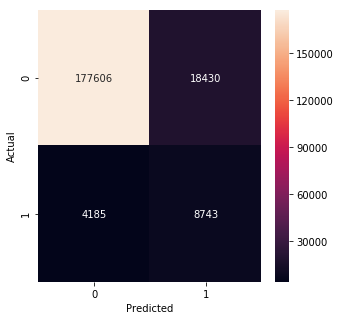

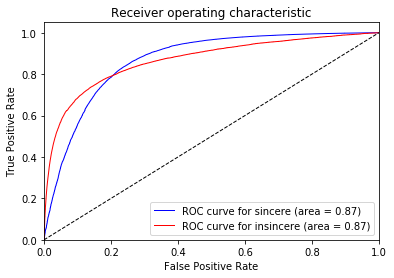

In [13]:
report(nbModel, X_test, y_test, test_compare, 'nbModel')

In [14]:
%%time

#for Algorithm (logisticRegression)
from sklearn.linear_model import LogisticRegression

lgModel = LogisticRegression(solver='liblinear', random_state=42,class_weight='balanced').fit(X_train, y_train)


CPU times: user 16.1 s, sys: 232 ms, total: 16.3 s
Wall time: 4.13 s


LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=42, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)
              precision    recall  f1-score   support

     Sincere       0.97      0.89      0.93    196036
   Insincere       0.25      0.57      0.35     12928

    accuracy                           0.87    208964
   macro avg       0.61      0.73      0.64    208964
weighted avg       0.92      0.87      0.89    208964



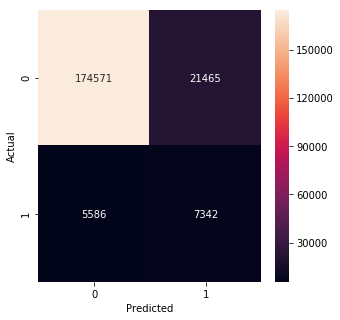

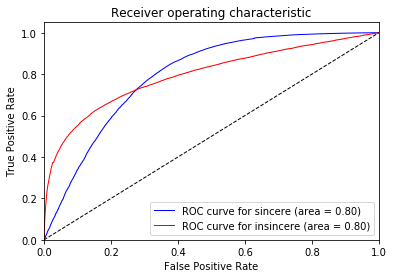

In [15]:
report(lgModel, X_test, y_test, test_compare, 'lgModel')

In [ ]:
%%time

#for Algorithm (SVC)
from sklearn.svm import SVC, LinearSVC

svcModel = SVC(random_state=42, gamma='scale', class_weight='balanced', probability=True).fit(X_train, y_train)


In [ ]:
report(svcModel, X_test, y_test, test_compare, 'svcModel')

In [ ]:
%%time

#for Algorithm (RandomForest)
from sklearn.ensemble import RandomForestClassifier

rfModel = RandomForestClassifier(random_state=42,class_weight='balanced').fit(X_train, y_train)


In [ ]:
report(rfModel, X_test, y_test, test_compare, 'rfModel')

In [ ]:
%%time

#for Algorithm (GradientBoosting)
from sklearn.ensemble import GradientBoostingClassifier

gbModel = GradientBoostingClassifier(random_state=42,).fit(X_train, y_train)


In [ ]:
report(gbModel, X_test, y_test, test_compare, 'gbModel')

In [ ]:
# report the diff for 5% data on algorithms 
for key in test_compare:
    print(key)
    print(test_compare[key])

## Step 6.2 hyperparameter Tuning (Grid Search) for Best Candidate Algorithm

compare result with the result from prototype in hold out set
plot grid seaarch, comparing with the LogisticRegression using SMOT data

In [ ]:
#all training data
filename = 'data/sample_X_train.sav'
X_train =load(filename)

filename = 'data/sample_y_train.sav'
y_train =load(filename)

hold_compare = {}

In [ ]:
%%time

from sklearn.linear_model import LogisticRegression
import numpy as np

param_grid = {'C': [0.001, 0.05, 0.1, 1, 10, 100], 'solver':['liblinear','newton-cg','lbfgs','sag'],}        
e = LogisticRegression(max_iter=1000, random_state=42, verbose=0)
searchLg = GridSearchCV(e, param_grid, cv=5, verbose=0, scoring='roc_auc')
searchLg.fit(X_train, y_train)
best= searchLg.best_estimator_ 
best.fit(X_test, y_test)

name = 'data/lrReSampledModel.sav'
dump(best, name)

report(best, X_hold, y_hold, hold_compare, 'LogisticRegression')

In [ ]:
%%time

from sklearn.ensemble import GradientBoostingClassifier
import numpy as np

param_grid = {'learning_rate' : [0.3, 0.8, 1.5] , 'n_estimators':[50, 100, 150], 
              'subsample' : [0.2, 0.5, 1.0], 'max_depth' : [5, 10, 20]} 
e = GradientBoostingClassifier(random_state=42, verbose=1)

searchBest = GridSearchCV(e, param_grid, cv=5, verbose=0, scoring='roc_auc')
searchBest.fit(X_train, y_train)
best= searchBest.best_estimator_ 
best.fit(X_test, y_test)

name = 'data/bestReSampledModel.sav'
dump(best, name)
report(best, X_hold, y_hold, hold_compare, 'Selected')

## Step 6.3 report the score for best model on hold out set 

<font color='red'>report </font>

In [ ]:
for key in hold_compare:
    print(key)
    print(hold_compare[key])


In [ ]:
plt.plot(searchBest.cv_results_['mean_test_score'], 'bo')
plt.plot(searchLg.cv_results_['mean_test_score'], 'ro')
plt.show()

## Step 7  CONVERT ALL STEPS INTO SPARK?!

<B>Reference</B>

Progress bar?  [Progress Bars in Python
](https://towardsdatascience.com/progress-bars-in-python-4b44e8a4c482),   Do we have progress bar for sklearn ? verbose=1 for now 

[How to graph grid scores from GridSearchCV?](https://stackoverflow.com/questions/37161563/how-to-graph-grid-scores-from-gridsearchcv)

[Multi-Class Text Classification Model Comparison and Selection](https://towardsdatascience.com/multi-class-text-classification-model-comparison-and-selection-5eb066197568)

<B>[Dealing with Imbalanced Data](https://towardsdatascience.com/methods-for-dealing-with-imbalanced-data-5b761be45a18)</B>

<B>information for next step</B>

<B>[A Comprehensive Guide to Understand and Implement Text Classification in Python](https://www.analyticsvidhya.com/blog/2018/04/a-comprehensive-guide-to-understand-and-implement-text-classification-in-python/)</B>

<B>[An implementation guide to Word2Vec using NumPy and Google Sheets](https://towardsdatascience.com/an-implementation-guide-to-word2vec-using-numpy-and-google-sheets-13445eebd281)</B>